<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 7.1: Decision Trees

INSTRUCTIONS:

- Read the guides and hints then create the necessary analysis and code to find and answer and conclusion for the scenario below.
- The baseline results (minimum) are:
    - **Accuracy** = 0.6895
    - **ROC AUC**  = 0.5690
- Try to achieve better results!

# Foreword
It is common that companies and professionals start with the data immediately available. Although this approach works, ideally the first step is to idenfy the problem or question and only then identify and obtain the set of data that can help to solve or answer the problem.

Also, given the current abundance of data, processing power and some particular machine learning methods, there could be a temptation to use ALL the data available. **Quality** is _**better**_ then **Quantity**!

Part of calling this discipline **Data Science** is that it is supposed to follow a process and not reach conclusions without support from evidence.

Moreover, it is a creative, exploratory, labour and iteractive processes. It is part of the process to repeat, review and change when finding a dead-end.

# Step 1: Define the problem or question
Identify the subject matter and the given or obvious questions that would be relevant in the field.

## Potential Questions
List the given or obvious questions.

## Actual Question
Choose the **one** question that should be answered.

-Based on the features given, are we able to predict if a person has donated blood on March 2007

# Step 2: Find the Data
### Blood Transfusion Service Center DataSet
- **Abstract**: Data taken from the **Blood Transfusion Service Center** in Hsin-Chu City in Taiwan.
- Date Donated: 2008-10-03
- Source:
        Original Owner and Donor: Prof. I-Cheng Yeh 
        Department of Information Management 
        Chung-Hua University, 
        Hsin Chu, Taiwan 30067, R.O.C. 

- Citation Request:
    **NOTE**: Reuse of this database is unlimited with retention of copyright notice for Prof. I-Cheng Yeh and the following published paper: 

        Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence, "Expert Systems with Applications, 2008
        
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

# Step 3: Read the Data
- Read the data
- Perform some basic structural cleaning to facilitate the work

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE

from collections import Counter

In [2]:
data =  pd.read_csv('transfusion.data', sep=",")

In [3]:
data.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [4]:
data.rename(columns={"Recency (months)": "months_since_last_donation"
                    , "Frequency (times)": "total_number_of_donation"
                    ,"Monetary (c.c. blood)":"total_mililitre_of_blood_donated"
                    ,"Time (months)" : "months_since_first_donation"
                    ,"whether he/she donated blood in March 2007": "donated_blood_in_march_2007"}, inplace =True)

# Step 4: Explore and Clean the Data
- Perform some initial simple **EDA** (Exploratory Data Analysis)
- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
    - **Null** (values not present or coded [as zero of empty strings])
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   months_since_last_donation        748 non-null    int64
 1   total_number_of_donation          748 non-null    int64
 2   total_mililitre_of_blood_donated  748 non-null    int64
 3   months_since_first_donation       748 non-null    int64
 4   donated_blood_in_march_2007       748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [6]:
data.describe()

,months_since_last_donation,total_number_of_donation,total_mililitre_of_blood_donated,months_since_first_donation,donated_blood_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [7]:
#Find if there is any null values 
data.isnull().sum()

months_since_last_donation          0
total_number_of_donation            0
total_mililitre_of_blood_donated    0
months_since_first_donation         0
donated_blood_in_march_2007         0
dtype: int64

# Step 5: Prepare the Data
- Deal with the data as required by the modelling technique
    - **Outliers** (remove or adjust if possible or necessary)
    - **Null** (remove or interpolate if possible or necessary)
    - **Missing Values** (remove or interpolate if possible or necessary)
    - **Coded content** (transform if possible or necessary [str to number or vice-versa])
    - **Normalisation** (if possible or necessary)
    - **Feature Engeneer** (if useful or necessary)

In [8]:
#Find z score of of each features
z = np.abs(stats.zscore(data))
print(z)

[[0.92789873 7.62334626 7.62334626 2.61563344 1.78948238]
 [1.17511806 1.28273826 1.28273826 0.2578809  1.78948238]
 [1.0515084  1.79684161 1.79684161 0.02947053 1.78948238]
 ...
 [1.66790417 0.43093957 0.43093957 1.13782607 0.55882081]
 [3.64565877 0.77367514 0.77367514 0.19367135 0.55882081]
 [7.72477762 0.77367514 0.77367514 1.54832812 0.55882081]]


In [9]:
print(np.where(z > 3))

(array([  0,   0,   4,   4,   9,   9, 115, 115, 341, 341, 495, 496, 497,
       498, 499, 500, 500, 502, 502, 503, 503, 504, 504, 505, 505, 517,
       517, 528, 528, 746, 747], dtype=int64), array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 0, 0], dtype=int64))


In [10]:
#Keep only records that are below 3 threshold
data_o = data[(z < 3).all(axis=1)]

In [11]:
data_o.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 1 to 745
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   months_since_last_donation        729 non-null    int64
 1   total_number_of_donation          729 non-null    int64
 2   total_mililitre_of_blood_donated  729 non-null    int64
 3   months_since_first_donation       729 non-null    int64
 4   donated_blood_in_march_2007       729 non-null    int64
dtypes: int64(5)
memory usage: 34.2 KB


# Step 6: Modelling
Refer to the Problem and Main Question.
- What are the input variables (features)?

    -months_since_last_donation, total_number_of_donation, total_mililitre_of_blood_donated, months_since_first_donation
    
- Is there an output variable (label)?

    -donated_blood_in_march_2007
    
- If there is an output variable:
    - What is it?
    - What is its type?
    
    It's integer.
    
- What type of Modelling is it?
    - [X] Supervised
    - [ ] Unsupervised 
    
- What type of Modelling is it?
    - [ ] Regression
    - [X] Classification (binary) 
    - [ ] Classification (multi-class)
    - [ ] Clustering

# Step 7: Split the Data

Need to check for **Supervised** modelling:
- Number of known cases or observations
- Define the split in Training/Test or Training/Validation/Test and their proportions
- Check for unbalanced classes and how to keep or avoid it when spliting

In [12]:
#Check distribution of target feature
data_o['donated_blood_in_march_2007'].value_counts()
#Seems to have an imbalanced distribution on the people who donated blood in march 2007

0    558
1    171
Name: donated_blood_in_march_2007, dtype: int64

In [13]:
#Defining target features
y = data_o['donated_blood_in_march_2007']
X = data_o[[i for i in data_o.columns if i != 'donated_blood_in_march_2007']] 

In [14]:
#Split original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #70% training and 30% test

In [15]:
counter = Counter(y_train)
print(counter)

Counter({0: 391, 1: 119})


In [16]:
#Since distrition of the outcome is not balanced, will use SMOTE to balance it 
#Instantiate SMOTE
os = SMOTE()

In [17]:
#Oversample value equal to zero to balance the dataset
X_train_smote, y_train_smote = os.fit_resample(X_train, y_train)
counter_smote = Counter(y_train_smote)
print(counter_smote)

Counter({0: 391, 1: 391})


# Step 8: Define a Model

Define the model and its hyper-parameters.

Consider the parameters and hyper-parameters of each model at each (re)run and after checking the efficiency of a model against the training and test datasets.

In [18]:
# Fit the classifier with hyper-parameters
clf = DecisionTreeClassifier(max_depth =3)

In [19]:
clf_smote = DecisionTreeClassifier(max_depth =3)

# Step 9: Fit the Model

In [20]:
#Fit model with original data(imbalanced data) 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [21]:
#Fit model with smote data(balanced data) 
clf_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=3)

# Step 10: Verify and Evaluate the Training Model
- Use the **training** data to make predictions
- Check for overfitting
- What metrics are appropriate for the modelling approach used
- For **Supervised** models:
    - Check the **Training Results** with the **Training Predictions** during development
- Analyse, modify the parameters and hyper-parameters and repeat (within reason) until the model does not improve

In [22]:
#Find out the accuracy score and ROC AUC - Original Dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Accuracy: 0.726027397260274
ROC AUC: 0.6507369875633349


In [23]:
#Do cross value score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [24]:
from numpy import mean
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.714


In [25]:
#Find out the accuracy score and ROC AUC - Smote
y_pred_smote = clf_smote.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, clf_smote.predict_proba(X_test)[:,1]))

Accuracy: 0.6118721461187214
ROC AUC: 0.6198756333486872


In [26]:
#Do cross value score
scores_smote = cross_val_score(clf_smote, X_train_smote, y_train_smote, scoring='roc_auc', cv=cv, n_jobs=-1)

In [27]:
print('Mean ROC AUC: %.3f' % mean(scores_smote))

Mean ROC AUC: 0.762


In [28]:
#Use Gridsearch to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

tree_para = {'criterion':['gini','entropy'],'max_depth':[2,3,4,5,6,7,8,9,10]}
gs = GridSearchCV(estimator=clf, param_grid=tree_para, n_jobs=-1, scoring='roc_auc', cv=cv)
gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'gini', 'max_depth': 3}

In [29]:
#Find the best roc_auc score for original data set
gs.best_score_

0.7135311367631126

In [30]:
#Fid the model with smote dataset
gs.fit(X_train_smote, y_train_smote)
gs.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [31]:
#Find the best roc_auc score for smote data set
gs.best_score_

0.8029329887898536

# Step 11: Make Predictions and Evaluate the Test Model
**NOTE**: **Do this only after not making any more improvements in the model**.

- Use the **test** data to make predictions
- For **Supervised** models:
    - Check the **Test Results** with the **Test Predictions**

## Imbalace Dataset

In [32]:
#Instantiate Decision Model with best hyperparameters for smote dataset
clf_best = DecisionTreeClassifier(criterion='gini', max_depth=3)

In [33]:
#Fit the model
clf_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [34]:
#Check the score
clf_best.score(X_test, y_test)

0.726027397260274

In [35]:
#Predictions
y_pred_best = clf_best.predict(X_test)

In [36]:
#Create confusion matrix based on actual and predictions
cf_matrix = confusion_matrix(y_test, y_pred_best)

Text(0.5, 1.0, 'Confusion Matrix - Original Dataset')

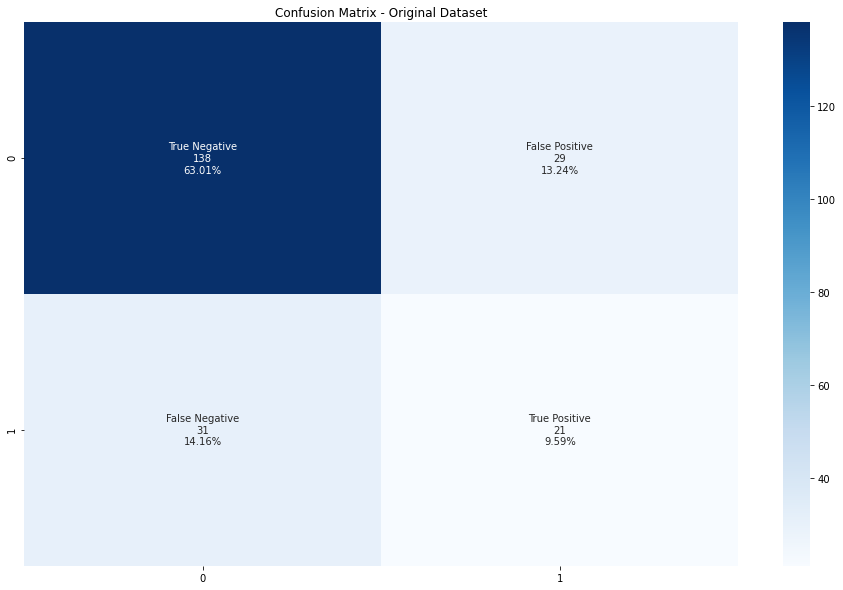

In [37]:
#Plot confusion matrix 
plt.figure(figsize=(16, 10))

group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

hm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
hm.set_title('Confusion Matrix - Original Dataset')

## Smote (Balanced Dataset)

In [38]:
#Instantiate Decision Model with best hyperparameters for smote dataset
clf_smote_best = DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [39]:
#Fit the model
clf_smote_best.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [40]:
#Check the score
clf_smote_best.score(X_test, y_test)

0.6210045662100456

In [41]:
#Predictions
y_pred_smote_best = clf_smote_best.predict(X_test)

In [42]:
#Create confusion matrix based on actual and predictions
cf_matrix_smote = confusion_matrix(y_test, y_pred_smote_best)

Text(0.5, 1.0, 'Confusion Matrix - SMOTE Dataset')

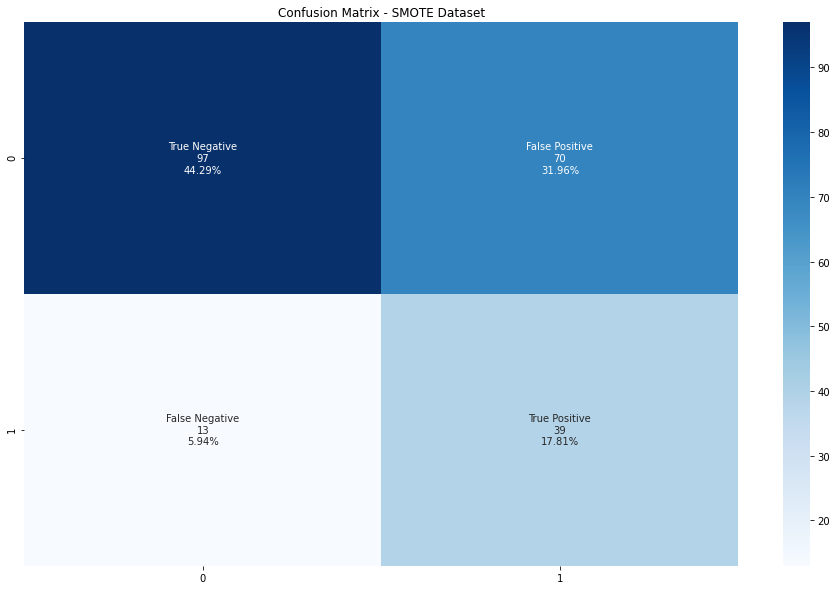

In [43]:
#Plot confusion matrix - SMOTE
plt.figure(figsize=(16, 10))

group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_smote.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_smote.flatten()/np.sum(cf_matrix_smote)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

hm = sns.heatmap(cf_matrix_smote, annot=labels, fmt='', cmap='Blues')
hm.set_title('Confusion Matrix - SMOTE Dataset')

# Step 12: Solve the Problem or Answer the Question
The results of an analysis or modelling can be used:
- As part of a product or process, so the model can make predictions when new input data is available
- As part of a report including text and charts to help understand the problem
- As input for further questions

Using original data set:

Accuracy = 0.726027397260274

ROC AUC = 0.7135311367631126



Using SMOTE the best: 

Accuracy = 0.6210045662100456

ROC AUC = 0.8029329887898536



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



